# Taller – Transformaciones Básicas en Computación Visual

**Entorno:** Python · Jupyter Notebook  
**Herramientas:** `numpy`, `matplotlib`, `imageio`

---

## Objetivo
Explorar los conceptos fundamentales de transformaciones geométricas — **traslación, rotación y escala** — usando matrices homogéneas 2D, y generar una animación exportada como GIF.

## 1. Import Required Libraries

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyArrowPatch
import imageio.v2 as imageio
import imageio as imageio_main
import io
import os

# Inline plots, high resolution
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['figure.facecolor'] = '#0f0f1a'
matplotlib.rcParams['text.color'] = 'white'

print("Libraries loaded successfully.")
print(f"  numpy   {np.__version__}")
print(f"  matplotlib {matplotlib.__version__}")
print(f"  imageio  {imageio_main.__version__}")

Libraries loaded successfully.
  numpy   2.2.6
  matplotlib 3.10.8
  imageio  2.37.2


## 2. Define 2D Transformation Matrices

All transformations are expressed as **3×3 homogeneous matrices** so that translation, rotation, and scale can be composed by plain matrix multiplication.

$$
T(t_x, t_y) = \begin{pmatrix} 1 & 0 & t_x \\ 0 & 1 & t_y \\ 0 & 0 & 1 \end{pmatrix}
\qquad
R(\theta) = \begin{pmatrix} \cos\theta & -\sin\theta & 0 \\ \sin\theta & \cos\theta & 0 \\ 0 & 0 & 1 \end{pmatrix}
\qquad
S(s_x, s_y) = \begin{pmatrix} s_x & 0 & 0 \\ 0 & s_y & 0 \\ 0 & 0 & 1 \end{pmatrix}
$$

Combined transform (scale → rotate → translate):
$$M = T \cdot R(\theta) \cdot S$$

In [5]:
def translation_matrix(tx: float, ty: float) -> np.ndarray:
    """3x3 homogeneous translation matrix."""
    return np.array([[1, 0, tx],
                     [0, 1, ty],
                     [0, 0,  1]], dtype=float)

def rotation_matrix(theta: float) -> np.ndarray:
    """3x3 homogeneous rotation matrix (angle in radians, CCW)."""
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[ c, -s, 0],
                     [ s,  c, 0],
                     [ 0,  0, 1]], dtype=float)

def scale_matrix(sx: float, sy: float) -> np.ndarray:
    """3x3 homogeneous scale matrix."""
    return np.array([[sx,  0, 0],
                     [ 0, sy, 0],
                     [ 0,  0, 1]], dtype=float)

def apply_transform(M: np.ndarray, points: np.ndarray) -> np.ndarray:
    """Apply a 3x3 matrix M to Nx2 points using homogeneous coordinates."""
    # points: (N, 2)  → homogeneous: (N, 3)
    ones = np.ones((points.shape[0], 1))
    h_pts = np.hstack([points, ones])        # (N, 3)
    transformed = (M @ h_pts.T).T           # (N, 3)
    return transformed[:, :2]               # back to (N, 2)

# Quick sanity-check: print all three canonical matrices
print("T(2, 3):\n", translation_matrix(2, 3))
print("\nR(π/4):\n", np.round(rotation_matrix(np.pi / 4), 3))
print("\nS(2, 0.5):\n", scale_matrix(2, 0.5))

T(2, 3):
 [[1. 0. 2.]
 [0. 1. 3.]
 [0. 0. 1.]]

R(π/4):
 [[ 0.707 -0.707  0.   ]
 [ 0.707  0.707  0.   ]
 [ 0.     0.     1.   ]]

S(2, 0.5):
 [[2.  0.  0. ]
 [0.  0.5 0. ]
 [0.  0.  1. ]]


## 3. Create a Base 2D Figure

We define an **arrow-shaped polygon** centred at the origin using homogeneous coordinates.  
The vertices are stored as an `(N, 2)` NumPy array and the shape is closed by repeating the first vertex when plotting.

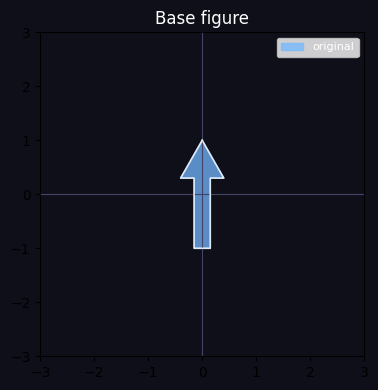

In [6]:
# Arrow polygon – vertices in (x, y) form, centred at origin
#
#      (0.0, 1.0)          ← tip
#     /            \
# (−0.4, 0.3)  (0.4, 0.3)
#     |              |
# (−0.15, 0.3)──(0.15, 0.3)   ← shaft top
#     |              |
# (−0.15,−1.0)──(0.15,−1.0)  ← shaft base

ARROW = np.array([
    [ 0.00,  1.00],   # tip
    [ 0.40,  0.30],   # right shoulder
    [ 0.15,  0.30],   # right shaft–top
    [ 0.15, -1.00],   # right shaft–base
    [-0.15, -1.00],   # left shaft–base
    [-0.15,  0.30],   # left shaft–top
    [-0.40,  0.30],   # left shoulder
], dtype=float)

def plot_shape(ax, pts, color='#74b9ff', alpha=0.75, label=''):
    """Fill and outline a polygon (auto-closed)."""
    closed = np.vstack([pts, pts[0]])       # close the polygon
    ax.fill(closed[:, 0], closed[:, 1], color=color, alpha=alpha, label=label)
    ax.plot(closed[:, 0], closed[:, 1], color='white', lw=1.2, alpha=0.8)

# ── Plot original figure ──────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_facecolor('#0f0f1a')
ax.set_xlim(-3, 3); ax.set_ylim(-3, 3)
ax.axhline(0, color='#444466', lw=0.8)
ax.axvline(0, color='#444466', lw=0.8)
ax.set_aspect('equal')
ax.set_title('Base figure', color='white')

plot_shape(ax, ARROW, color='#74b9ff', label='original')
ax.legend(loc='upper right', fontsize=8)
plt.tight_layout()
plt.show()

## 4. Apply Static Transformations

Each transformation is applied **independently** to the base figure so the effect is clear.  
The original shape is shown in blue for reference.


Translation  T(1.5, 0.5):
[[1.  0.  1.5]
 [0.  1.  0.5]
 [0.  0.  1. ]]

Rotation  R(π/3):
[[ 0.5   -0.866  0.   ]
 [ 0.866  0.5    0.   ]
 [ 0.     0.     1.   ]]

Scale  S(1.8, 0.6):
[[1.8 0.  0. ]
 [0.  0.6 0. ]
 [0.  0.  1. ]]


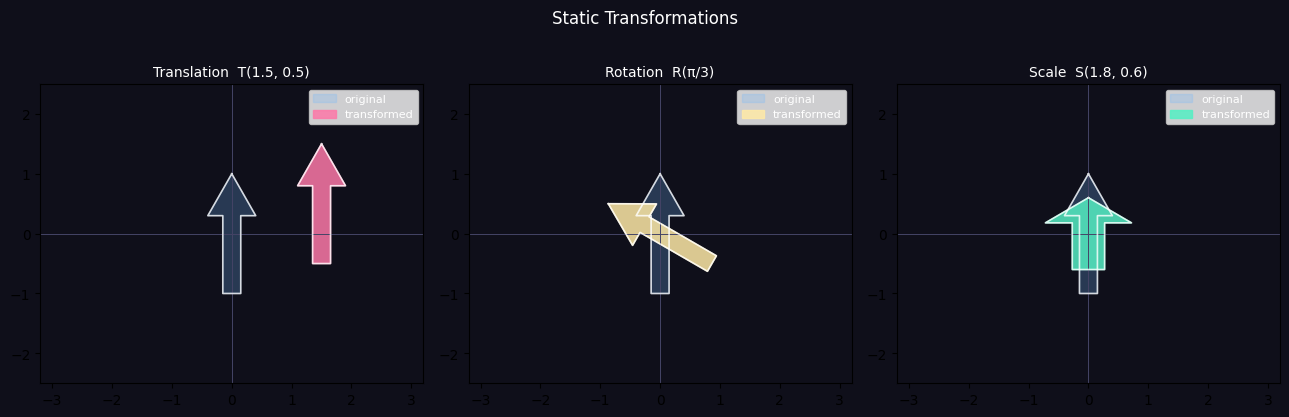

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4))
titles       = ['Translation  T(1.5, 0.5)', 'Rotation  R(π/3)', 'Scale  S(1.8, 0.6)']
transforms   = [
    translation_matrix(1.5, 0.5),
    rotation_matrix(np.pi / 3),
    scale_matrix(1.8, 0.6),
]
result_colors = ['#fd79a8', '#ffeaa7', '#55efc4']

for ax, title, M, color in zip(axes, titles, transforms, result_colors):
    ax.set_facecolor('#0f0f1a')
    ax.set_xlim(-3.2, 3.2); ax.set_ylim(-2.5, 2.5)
    ax.axhline(0, color='#444466', lw=0.7)
    ax.axvline(0, color='#444466', lw=0.7)
    ax.set_aspect('equal')
    ax.set_title(title, color='white', fontsize=10)

    # Original (faded)
    plot_shape(ax, ARROW, color='#74b9ff', alpha=0.25, label='original')

    # Transformed
    pts_t = apply_transform(M, ARROW)
    plot_shape(ax, pts_t, color=color, alpha=0.85, label='transformed')

    # Print matrix
    print(f"\n{title}:\n{np.round(M, 3)}")

    ax.legend(loc='upper right', fontsize=8)

plt.suptitle('Static Transformations', color='white', y=1.02)
plt.tight_layout()
plt.show()

## 5. Animate Transformations Over Time

We sweep a **time parameter** $t \in [0, 2\pi]$ over `N_FRAMES` steps and, at each frame, compose:

$$
M(t) = T\!\left(A\sin(\omega t),\; B\sin(2\omega t)\right) \cdot R(\omega t) \cdot S\!\left(s_0 + a\sin(2t),\; s_0 + a\sin(2t)\right)
$$

Each frame is rendered with matplotlib and captured into a list of RGBA arrays.

In [8]:
N_FRAMES = 72          # frames in one full cycle
OMEGA    = 1.0         # angular frequency (rad / normalised time unit)
A_TX     = 1.8         # translation amplitude X
A_TY     = 0.9         # translation amplitude Y
S_BASE   = 0.9         # base scale
S_AMP    = 0.45        # scale oscillation amplitude

frames = []            # list of (H, W, 3) uint8 arrays

for i in range(N_FRAMES):
    t = 2 * np.pi * i / N_FRAMES    # t ∈ [0, 2π)

    # ── Build combined transformation matrix M(t) ──────────────────────────
    T = translation_matrix(A_TX * np.sin(OMEGA * t),
                           A_TY * np.sin(2 * OMEGA * t))
    R = rotation_matrix(OMEGA * t)
    s = S_BASE + S_AMP * np.sin(2 * t)
    S = scale_matrix(s, s)

    M = T @ R @ S        # compose: scale → rotate → translate

    pts = apply_transform(M, ARROW)

    # ── Render frame ───────────────────────────────────────────────────────
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_facecolor('#0f0f1a')
    fig.patch.set_facecolor('#0f0f1a')
    ax.set_xlim(-3.5, 3.5); ax.set_ylim(-3.5, 3.5)
    ax.axhline(0, color='#333355', lw=0.6)
    ax.axvline(0, color='#333355', lw=0.6)
    ax.set_aspect('equal')
    ax.axis('off')

    # Ghost of original
    plot_shape(ax, ARROW, color='#2980b9', alpha=0.12)

    # Animated shape – colour cycles with hue
    hue = (i / N_FRAMES)
    color = plt.cm.hsv(hue)
    plot_shape(ax, pts, color=color, alpha=0.88)

    # Time label
    ax.set_title(f't = {t:.2f} rad   s = {s:.2f}   θ = {OMEGA*t:.2f} rad',
                 color='#dfe6e9', fontsize=9, pad=4)

    # Capture to numpy array
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight',
                facecolor=fig.get_facecolor())
    buf.seek(0)
    frame_img = imageio.imread(buf)[:, :, :3]   # drop alpha channel
    frames.append(frame_img)
    plt.close(fig)

print(f"Captured {len(frames)} frames – shape of one frame: {frames[0].shape}")

Captured 72 frames – shape of one frame: (420, 404, 3)


## 6. Export Animation as GIF

The captured frames are compiled into a single animated GIF and saved to `../media/transformaciones.gif`, then displayed inline.

In [9]:
GIF_PATH = os.path.join('..', 'media', 'transformaciones.gif')
os.makedirs(os.path.dirname(GIF_PATH), exist_ok=True)

# Write GIF (duration per frame in seconds)
imageio.mimsave(GIF_PATH, frames, duration=1 / 24, loop=0)
print(f"GIF saved → {os.path.abspath(GIF_PATH)}")
print(f"  Frames : {len(frames)}")
print(f"  Size   : {os.path.getsize(GIF_PATH) / 1024:.1f} KB")

GIF saved → /home/ivan/dev/visualcomputing2026/semana_1_4_transformaciones/media/transformaciones.gif
  Frames : 72
  Size   : 244.9 KB


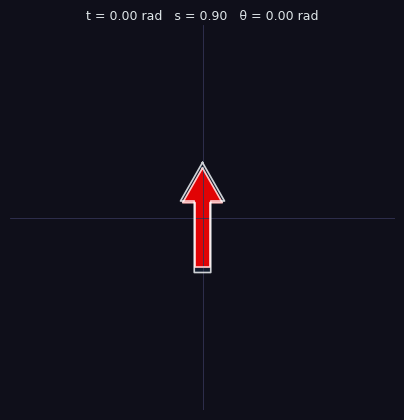

In [10]:
from IPython.display import Image, display

display(Image(filename=GIF_PATH, width=400))